# Table of Contents
 <p>

In [1]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
%matplotlib inline

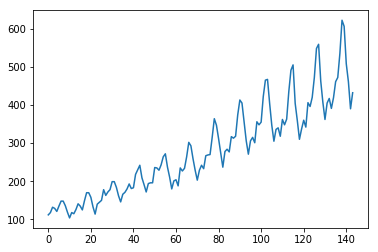

In [3]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('~/Downloads/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

In [41]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [42]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [43]:
# load the dataset
dataframe = pandas.read_csv('~/Downloads/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [138]:
from pycbc import waveform
hp, _ = waveform.get_td_waveform(approximant="SEOBNRv4_opt",
                                mass1=30,
                                mass2=30,
                                f_lower=40,
                                delta_t=1./1024)

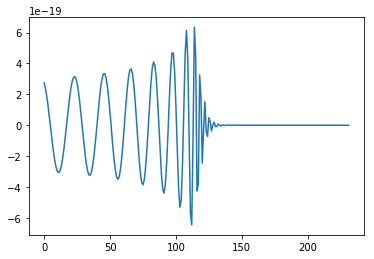

In [156]:
plt.plot(hp)

In [157]:
dataset = numpy.array(hp.numpy().tolist())[0:150]

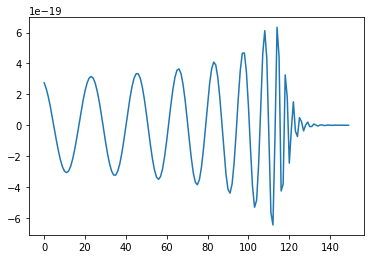

In [158]:
plt.plot(dataset)

In [159]:
dataset = dataset.reshape(len(dataset),1)

In [160]:
dataset.shape

(150, 1)

In [161]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [162]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(100, 50)


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [163]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [164]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [165]:
print(trainX[:3])
print(trainY[:2])

[[0.71869987]
 [0.68963264]
 [0.64907239]]
[0.68963264 0.64907239]


In [166]:
trainX.shape

(98, 1)

In [167]:
trainY.shape

(98,)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [168]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [169]:
# create the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [170]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [171]:
# fit the LSTM network
hist = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.1626
Epoch 2/100
 - 0s - loss: 0.0715
Epoch 3/100
 - 0s - loss: 0.0323
Epoch 4/100
 - 0s - loss: 0.0203
Epoch 5/100
 - 0s - loss: 0.0179
Epoch 6/100
 - 0s - loss: 0.0167
Epoch 7/100
 - 0s - loss: 0.0158
Epoch 8/100
 - 0s - loss: 0.0145
Epoch 9/100
 - 0s - loss: 0.0134
Epoch 10/100
 - 0s - loss: 0.0123
Epoch 11/100
 - 0s - loss: 0.0112
Epoch 12/100
 - 0s - loss: 0.0101
Epoch 13/100
 - 0s - loss: 0.0090
Epoch 14/100
 - 0s - loss: 0.0082
Epoch 15/100
 - 0s - loss: 0.0074
Epoch 16/100
 - 0s - loss: 0.0066
Epoch 17/100
 - 0s - loss: 0.0061
Epoch 18/100
 - 0s - loss: 0.0056
Epoch 19/100
 - 0s - loss: 0.0053
Epoch 20/100
 - 0s - loss: 0.0051
Epoch 21/100
 - 0s - loss: 0.0049
Epoch 22/100
 - 0s - loss: 0.0049
Epoch 23/100
 - 0s - loss: 0.0047
Epoch 24/100
 - 0s - loss: 0.0048
Epoch 25/100
 - 0s - loss: 0.0046
Epoch 26/100
 - 0s - loss: 0.0045
Epoch 27/100
 - 0s - loss: 0.0045
Epoch 28/100
 - 0s - loss: 0.0046
Epoch 29/100
 - 0s - loss: 0.0046
Epoch 30/100
 - 0s - lo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).



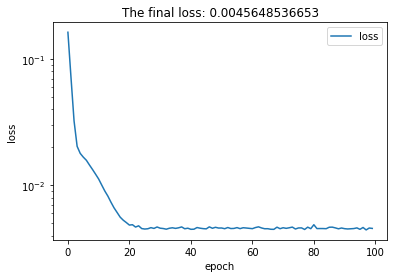

In [173]:
for label in ["loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final loss: {}".format(hist.history["loss"][-1]))
plt.legend()
plt.yscale('log')
plt.show()

In [174]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.16f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.16f RMSE' % (testScore))

Train Score: 0.0000000000000000 RMSE
Test Score: 0.0000000000000000 RMSE


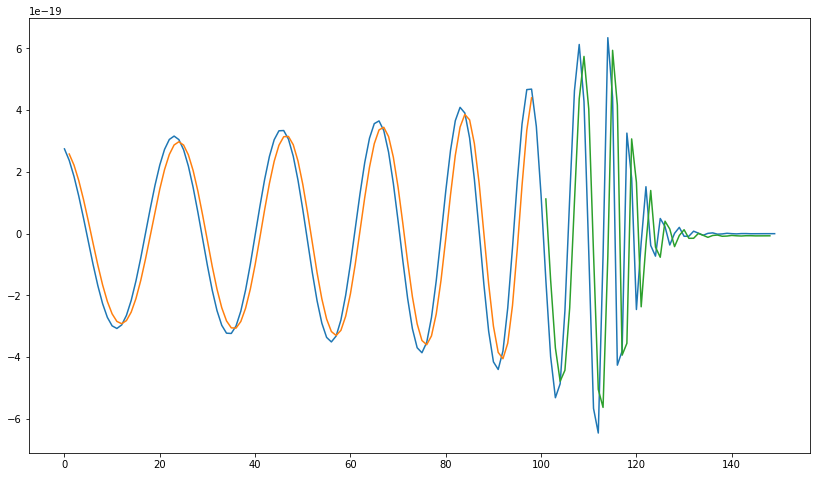

In [175]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(14,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()